## Slicing NAM model for SPECFEM3D_Cart

---

In [1]:
from sys import argv
import numpy as np
import pandas as pd
import scipy as sp
from scipy import ndimage
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import shapefile as sf
from scipy.interpolate import RegularGridInterpolator
from gnam.model.gridmod3d import gridmod3d as gm
from gnam.model.bbox import bbox as bb
from shapely.geometry import Point, Polygon

### Load numpy array from NAM model

In [2]:
#this is a pickled dictionary with 4D ndarray, and 1D meta data arrays
ifilename = './rect_gron_model_full_z10_props.npz'

#Unpickle
data = np.load(ifilename)
props = data['props'] #4D ndarray

#meta data arrays
xdata = data['xd'] 
ydata = data['yd']
zdata = data['zd']

print('xd:\n',xdata)
print('yd:\n',ydata)
print('zd:\n',zdata)

# Setup Coordinate related vars
xmin = xdata[0]
dx   = xdata[1]
nx   = int(xdata[2])
xmax = xmin + (nx-1)*dx

ymin = ydata[0]
dy   = ydata[1]
ny   = int(ydata[2])
ymax = ymin + (ny-1)*dy

zmin = zdata[0]
dz   = zdata[1]
nz   = int(zdata[2])
zmax = (-zmin) + (nz-1)*dz

xd:
 [2.074625e+05 5.000000e+01 1.450000e+03]
yd:
 [5.559625e+05 5.000000e+01 1.198000e+03]
zd:
 [  0.  10. 601.]


### Create Gridded Model 

In [3]:
nsub_props = props.shape[0]
axes_order = {'X':0,'Y':1,'Z':2} #this dict keeps track of axes order
gm3d = gm(props,nsub_props,axes_order,(nx,ny,nz),(dx,dy,dz),(xmin,ymin,zmin))
print('gm3d.shape:',gm3d.shape)



gm3d.shape: (3, 1450, 1198, 601)


### Plot subsurface slice

surf.shape (1198, 1450)
xc.shape:
 (1450,)
yc.shape:
 (1198,)
zc.shape:
 (1198,)


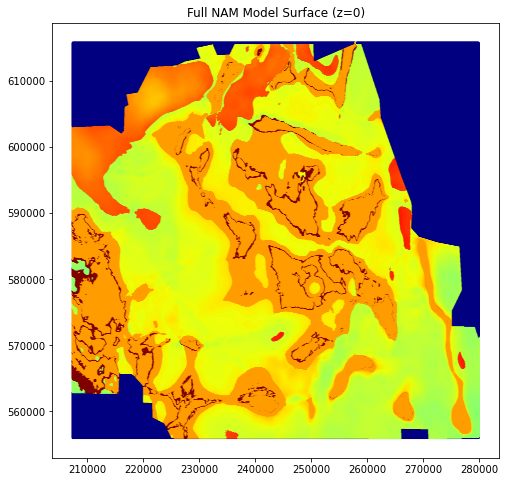

In [4]:
#Slice the z=0 depth slice from gm3d
surf = gm3d.depthValsSliceFromZIndex(200)[0]
print('surf.shape',surf.shape)

#get x,y,z coordinates
xc = gm3d.getLocalCoordsPointsX() + xmin
yc = gm3d.getLocalCoordsPointsY() + ymin
zc = gm3d.getLocalCoordsPointsY() + zmin

print('xc.shape:\n',xc.shape)
print('yc.shape:\n',yc.shape)
print('zc.shape:\n',zc.shape)

#get xy coordinate pairs for ploting
xyc = np.transpose([np.tile(xc, len(yc)), np.repeat(yc, len(xc))])

#get min max to normalize surface
vp_min = np.min(surf)
vp_max = np.max(surf)
surf_norm = Normalize(vp_min,vp_max)

fig, ax = plt.subplots(1,figsize=(8,8))
ax.scatter(xyc[:,0],xyc[:,1],s=1,c=surf.flatten(),cmap=plt.cm.jet,norm=surf_norm)
ax.set_title('Full NAM Model Surface (z=0)')
plt.show()

### Smooth Subsurface

In [5]:
# set sigmas
#z_sig = 3*(50/dz) # tested at dz=10m and was good, so assume scale by that)
#y_sig = z_sig*(dz/dy)
#x_sig = z_sig*(dz/dx)

# smooth
#gm3d.smoothXYZ(x_sig,y_sig,z_sig)

# get new smoothed surface
#surf = gm3d.depthValsSliceFromZIndex(200)[0]
#print('surf.shape',surf.shape)

# get new min max to normalize surface
#vp_min = np.min(surf)
#vp_max = np.max(surf)
#surf_norm = Normalize(vp_min,vp_max)

#fig, ax = plt.subplots(1,figsize=(8,8))
#ax.scatter(xyc[:,0],xyc[:,1],s=1,c=surf.flatten(),cmap=plt.cm.jet,norm=surf_norm)
#ax.set_title('Full NAM Model Surface (z=0)')
#plt.show()



### Subsample model to reduce memory foot print

In [6]:
gm3d.subsample(2,2,10)
print('gm3d.shape:',gm3d.shape)

gm3d.shape: (3, 725, 599, 61)


### Setup coordinate arryas for plotting and slicing

xc.shape:
 (725,)
yc.shape:
 (599,)
zc.shape:
 (599,)
surf.shape (599, 725)


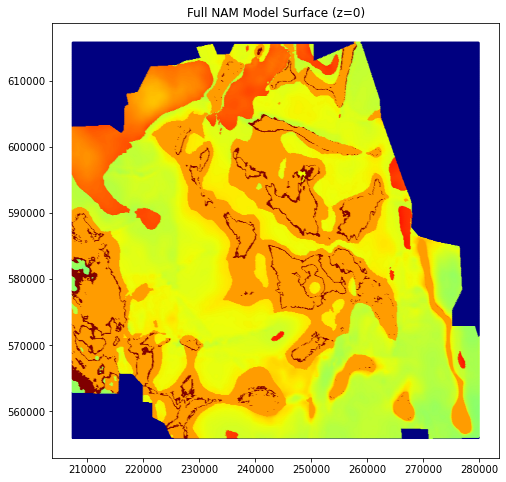

In [7]:
xc = gm3d.getLocalCoordsPointsX() + xmin
yc = gm3d.getLocalCoordsPointsY() + ymin
zc = gm3d.getLocalCoordsPointsY() + zmin

# get new xy coordinate pairs for ploting
xyc = np.transpose([np.tile(xc, len(yc)), np.repeat(yc, len(xc))])

print('xc.shape:\n',xc.shape)
print('yc.shape:\n',yc.shape)
print('zc.shape:\n',zc.shape)

# get new smoothed surface
surf = gm3d.depthValsSliceFromZIndex(20)[0]
print('surf.shape',surf.shape)

# get new min max to normalize surface
vp_min = np.min(surf)
vp_max = np.max(surf)
surf_norm = Normalize(vp_min,vp_max)

fig, ax = plt.subplots(1,figsize=(8,8))
ax.scatter(xyc[:,0],xyc[:,1],s=1,c=surf.flatten(),cmap=plt.cm.jet,norm=surf_norm)
ax.set_title('Full NAM Model Surface (z=0)')
plt.show()


### Read seismometer coordinates file and process for coordinates

In [2]:
import pandas as pd
import numpy as np

# read file
df = pd.io.parsers.read_csv("Gloc.csv",sep=",",index_col=0)
print(df)
print()

# remove Lat and Lon and surf elevation
df = df.drop(columns=['Latitude [deg]', 'Longitude [deg]', 'Surface elevation [m]'])
print('Dropped Lat, Lon, Surf')
print(df)
print()

# remove receivers unless depth is 200 meters
df = df[df['Depth below surface [deg]'] > 100 ]
print('Remove Shallow')
print(df)
print()

# drop this column
df = df.drop(columns=['Depth below surface [deg]'])
print('Dropped Depth')
print(df[:10])
print()

#get rec_x
rec_x = df[['Rijksdriehoek X [m]']].to_numpy().astype(np.float32)
#reshape to vector of only one dim
rec_x = rec_x.reshape(rec_x.shape[0])

#get rec_y
rec_y = df[['Rijksdriehoek Y [m]']].to_numpy().astype(np.float32)
#reshape to vector of only one dim
rec_y = rec_y.reshape(rec_y.shape[0])

              Latitude [deg]  Longitude [deg]  Rijksdriehoek X [m]  \
Station name                                                         
G010                53.44253         6.731191             244304.6   
G011                53.44253         6.731191             244304.6   
G012                53.44253         6.731191             244304.6   
G013                53.44253         6.731191             244304.6   
G014                53.44253         6.731191             244304.6   
...                      ...              ...                  ...   
G760                53.35072         6.390067             221781.6   
G770                53.34029         6.330437             217826.2   
G780                53.36482         6.489397             228371.6   
G790                53.38356         6.331927             217862.1   
G800                53.41537         6.487625             228167.6   

              Rijksdriehoek Y [m]  Depth below surface [deg]  \
Station name             

### Plot overlay of seismometer locations

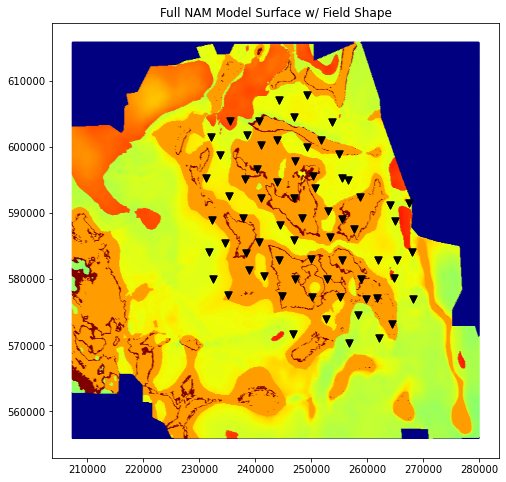

In [9]:
fig, ax = plt.subplots(1,figsize=(8,8))
ax.scatter(xyc[:,0],xyc[:,1],s=1,c=surf.flatten(),cmap=plt.cm.jet,norm=surf_norm,zorder=0)
ax.scatter(rec_x,rec_y,s=50,c='black',marker='v',zorder=1)
ax.set_title('Full NAM Model Surface w/ Field Shape')
plt.show()

### Read Groningen Shape file

In [10]:
mysf = sf.Reader('FieldShapeFile/Groningen_field')
print('mysf:',mysf)
print('mysf.shapes():',mysf.shapes())
s = mysf.shape(0)

mysf: shapefile Reader
    1 shapes (type 'POLYGON')
    1 records (15 fields)
mysf.shapes(): Shapes: [<shapefile.Shape object at 0x298f58eb8>]


### Get Coordinates for Groningen Field Shape and plot

[[244553.66791253 611725.20421346]
 [244547.0077105  611700.64330227]
 [244541.78889146 611680.00392532]
 ...
 [251194.37084925 611377.46280287]
 [251176.85301841 611369.94869857]
 [251154.70985694 611367.06276124]]


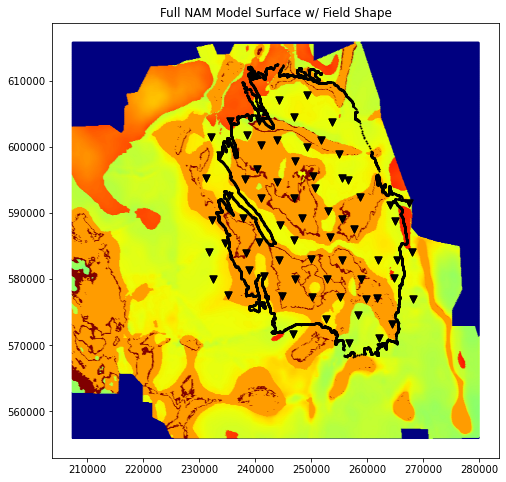

In [11]:
mypoints = np.asarray(s.points)
print(mypoints)

fig, ax = plt.subplots(1,figsize=(8,8))
ax.scatter(xyc[:,0],xyc[:,1],s=1,c=surf.flatten(),cmap=plt.cm.jet,norm=surf_norm,zorder=0)
ax.scatter(rec_x,rec_y,s=50,c='black',marker='v',zorder=1)
ax.scatter(mypoints[:,0],mypoints[:,1],s=1,c='black',zorder=2)
ax.set_title('Full NAM Model Surface w/ Field Shape')
plt.show()

### Get and plot bounding box of the ShapeFile

mybbox: [232934.69164335277, 568234.2178180774, 267116.2338591757, 612509.643549165]


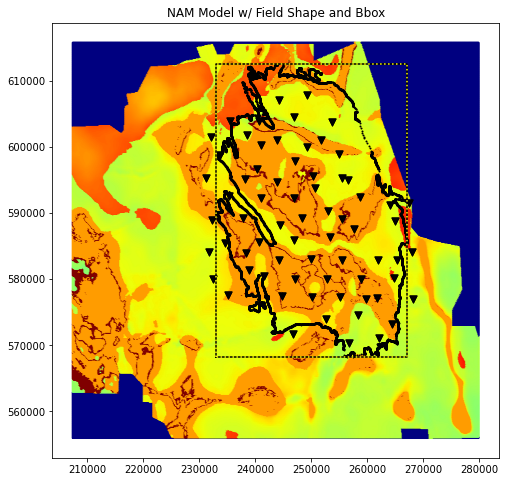

In [12]:
mybbox = s.bbox #this will be used for slicing (look further down)
print('mybbox:',mybbox)

pbbox_x = np.array([mybbox[0],mybbox[0],mybbox[2],mybbox[2],mybbox[0]])
pbbox_y = np.array([mybbox[1],mybbox[3],mybbox[3],mybbox[1],mybbox[1]])

c_loop = np.array([[mybbox[0],mybbox[1]],[mybbox[0],mybbox[3]],
                   [mybbox[2],mybbox[3]],[mybbox[2],mybbox[1]],
                   [mybbox[0],mybbox[1]]])

gf_bbox = bb(c_loop)

fig, ax = plt.subplots(1,figsize=(8,8))
ax.scatter(xyc[:,0],xyc[:,1],s=1,c=surf.flatten(),cmap=plt.cm.jet,norm=surf_norm,zorder=0)
ax.scatter(rec_x,rec_y,s=50,c='black',marker='v',zorder=1)
ax.scatter(mypoints[:,0],mypoints[:,1],s=1,c='black',zorder=2)
ax.plot(pbbox_x,pbbox_y,c='black',zorder=3)
ax.plot(gf_bbox.getCLoop()[:,0],gf_bbox.getCLoop()[:,1],c='yellow',linestyle='dotted',zorder=3)
ax.set_title('NAM Model w/ Field Shape and Bbox')
plt.show()

### Define function for separating receivers that are in and out of the bounding box

In [13]:
def get_in_out_recs(bbox_x,bbox_y,_rec_x,_rec_y):
    xycoords = np.append(_rec_x,_rec_y).reshape((2,len(_rec_x))).T

    acoords = np.array([[bbox_x[0],bbox_y[0]],[bbox_x[1],bbox_y[1]],[bbox_x[2],bbox_y[2]],[bbox_x[3],bbox_y[3]]])
    boxcoords = list(map(tuple, acoords))
    #print('boxcoords:',boxcoords)

    poly = Polygon(boxcoords)
    #print('poly:',poly)

    xyPoints = list(map(Point, xycoords))
    is_iside = np.ones((len(xycoords[:,0])),dtype=bool)
    is_oside = np.zeros((len(xycoords[:,0])),dtype=bool)
    for i in range(len(xyPoints)):
        if not poly.contains(xyPoints[i]):
            is_iside[i] = False
            is_oside[i] = True

    #print('is_iside:\n', is_iside)

    i_stations = xycoords[is_iside]
    o_stations = xycoords[is_oside]
    
    return (i_stations,o_stations)

#irec, orec = get_in_out_recs(new_box_x,new_box_y,rec_x,rec_y)


### Plot NAM plus Field plus Bounding Box plus IN and OUT Seismometers

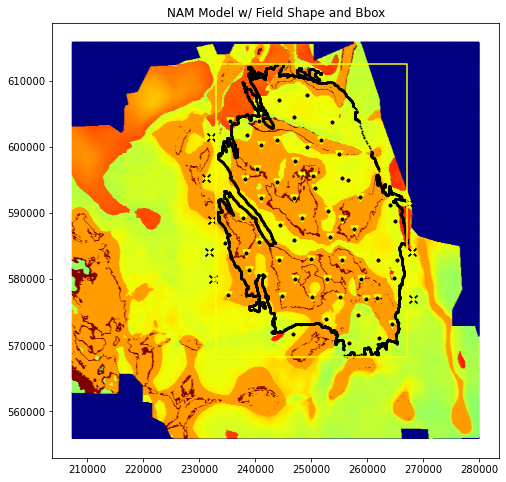

In [14]:
irec, orec = get_in_out_recs(pbbox_x,pbbox_y,rec_x,rec_y)
bbirec, bborec = gf_bbox.separateByInOut(rec_x,rec_y)

fig, ax = plt.subplots(1,figsize=(8,8))
ax.scatter(xyc[:,0],xyc[:,1],s=1,c=surf.flatten(),cmap=plt.cm.jet,norm=surf_norm,zorder=0)
#ax.scatter(rec_x,rec_y,s=50,c='black',marker='v',zorder=1)
ax.scatter(irec[:,0],irec[:,1],s=50,c='yellow',marker='v',zorder=1)
ax.scatter(orec[:,0],orec[:,1],s=60,c='black',marker='x',zorder=1)
ax.scatter(bbirec[:,0],bbirec[:,1],s=30,c='black',marker='.',zorder=1)
ax.scatter(bborec[:,0],bborec[:,1],s=30,c='yellow',marker='.',zorder=1)
ax.scatter(mypoints[:,0],mypoints[:,1],s=1,c='black',zorder=2)
ax.plot(pbbox_x,pbbox_y,c='yellow',zorder=3)
ax.set_title('NAM Model w/ Field Shape and Bbox')
plt.show()

### Shrink the bounding box for computational reasons and then create coordinates

nvl: 386.0
nvb: 291.0
xy.shape: (112326, 2)
Rotation: 0


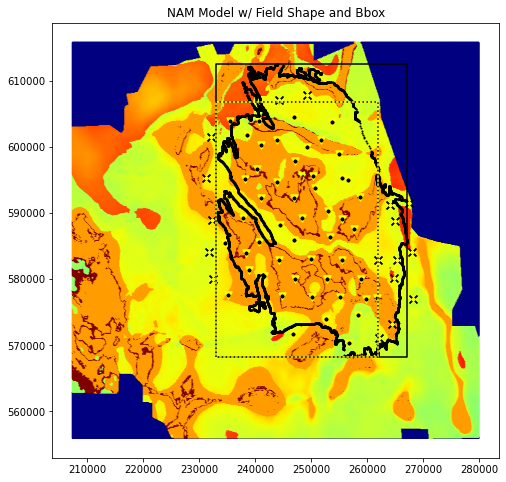

In [15]:
#shrink and create y coordinates for slicing box
vl = np.array([0,0.87*(mybbox[3]-mybbox[1])])
dvl = ((0.87*(mybbox[3]-mybbox[1]))**2)**0.5
nvl = dvl//100 + 1
y = np.arange(nvl)*100
print('nvl:',nvl)

#shrink and create x coordinates for slicing box
vb = np.array([0.85*(mybbox[2]-mybbox[0]),0])
dvb = ((0.85*(mybbox[2]-mybbox[0]))**2)**0.5
nvb = dvb//100 + 1
x = np.arange(nvb)*100
print('nvb:',nvb)

#create set of xy coordinates for slicing box
xy = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
print('xy.shape:',xy.shape)

#global origins
xy_xmin = np.min(x)
xy_xmax = np.max(x)
xy_ymin = np.min(y)
xy_ymax = np.max(y)

shnk_bbox_x = np.array([xy_xmin,xy_xmin,xy_xmax,xy_xmax,xy_xmin])
shnk_bbox_y = np.array([xy_ymin,xy_ymax,xy_ymax,xy_ymin,xy_ymin])
shnk_bbox_x += mybbox[0] #translate to global
shnk_bbox_y += mybbox[1] #translate to global

sc_loop = np.array([[xy_xmin,xy_ymin],[xy_xmin,xy_ymax],
                   [xy_xmax,xy_ymax],[xy_xmax,xy_ymin],
                   [xy_xmin,xy_ymin]])

sgf_bbox = bb(sc_loop)
sgf_bbox.translate(mybbox[0],mybbox[1])
print('Rotation:',sgf_bbox.getRotDeg())

irec, orec = get_in_out_recs(shnk_bbox_x,shnk_bbox_y,rec_x,rec_y)
bbirec, bborec = sgf_bbox.separateByInOut(rec_x,rec_y)

fig, ax = plt.subplots(1,figsize=(8,8))
ax.scatter(xyc[:,0],xyc[:,1],s=1,c=surf.flatten(),cmap=plt.cm.jet,norm=surf_norm,zorder=0)
#ax.scatter(rec_x,rec_y,s=50,c='black',marker='v',zorder=1)
ax.scatter(irec[:,0],irec[:,1],s=50,c='yellow',marker='v',zorder=1)
ax.scatter(orec[:,0],orec[:,1],s=60,c='black',marker='x',zorder=1)
ax.scatter(bbirec[:,0],bbirec[:,1],s=30,c='black',marker='.',zorder=2)
ax.scatter(bborec[:,0],bborec[:,1],s=30,c='yellow',marker='.',zorder=2)
ax.scatter(mypoints[:,0],mypoints[:,1],s=1,c='black',zorder=2)
ax.plot(pbbox_x,pbbox_y,c='black',zorder=3)
ax.plot(shnk_bbox_x,shnk_bbox_y,c='yellow',zorder=4)
ax.plot(sgf_bbox.getCLoop()[:,0],sgf_bbox.getCLoop()[:,1],c='black',linestyle='dotted',zorder=4)
ax.set_title('NAM Model w/ Field Shape and Bbox')
plt.show()


### Rotate the bounding box 

Rotation: 30


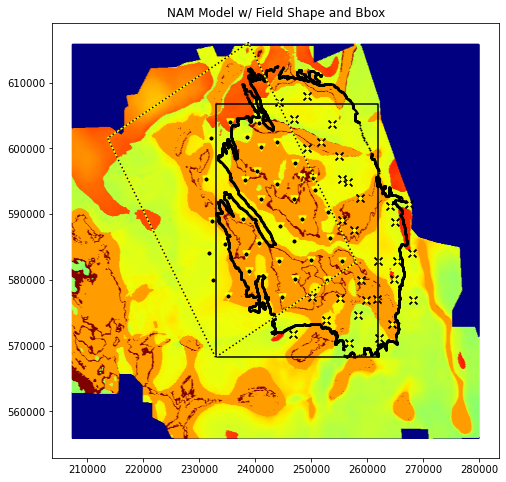

In [16]:
#setup rotation matrices
degree = 30
theta = degree*np.pi/180
rm = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
rmi = np.array([[np.cos(-theta),-np.sin(-theta)],[np.sin(-theta),np.cos(-theta)]])

#non rotated bounding box
rot_bx = np.array([xy_xmin,xy_xmin,xy_xmax,xy_xmax,xy_xmin])
rot_by = np.array([xy_ymin,xy_ymax,xy_ymax,xy_ymin,xy_ymin])

#yet to be rotated bounding box
rbbox_x = np.zeros_like(rot_bx)
rbbox_y = np.zeros_like(rot_by)

#rotate bounding box
rbbox_x[0] = rm.dot(np.array([rot_bx[0],rot_by[0]]))[0]
rbbox_y[0] = rm.dot(np.array([rot_bx[0],rot_by[0]]))[1]
rbbox_x[1] = rm.dot(np.array([rot_bx[1],rot_by[1]]))[0]
rbbox_y[1] = rm.dot(np.array([rot_bx[1],rot_by[1]]))[1]
rbbox_x[2] = rm.dot(np.array([rot_bx[2],rot_by[2]]))[0]
rbbox_y[2] = rm.dot(np.array([rot_bx[2],rot_by[2]]))[1]
rbbox_x[3] = rm.dot(np.array([rot_bx[3],rot_by[3]]))[0]
rbbox_y[3] = rm.dot(np.array([rot_bx[3],rot_by[3]]))[1]
rbbox_x[4] = rbbox_x[0]
rbbox_y[4] = rbbox_y[0]

#rotate coordinates
for i in range(len(xy[:,0])):
    xy[i,:] = rm.dot(xy[i,:])
    
#move box to global coordinate location to cover the Groningen Field (this was done by eye)
#play wiht the coordinate translations to movie bounding box
prbbox_x = np.copy(rbbox_x)
prbbox_y = np.copy(rbbox_y)
prbbox_x += mybbox[0]
prbbox_y += mybbox[1]

irec, orec = get_in_out_recs(prbbox_x,prbbox_y,rec_x,rec_y)

sgf_bbox.rotate(30)
bbirec, bborec = sgf_bbox.separateByInOut(rec_x,rec_y)
print('Rotation:',sgf_bbox.getRotDeg())

#Plot
fig, ax = plt.subplots(1,figsize=(8,8))
ax.scatter(xyc[:,0],xyc[:,1],s=1,c=surf.flatten(),cmap=plt.cm.jet,norm=surf_norm,zorder=0)
#ax.scatter(rec_x,rec_y,s=50,c='black',marker='v',zorder=1)
ax.scatter(irec[:,0],irec[:,1],s=50,c='yellow',marker='v',zorder=1)
ax.scatter(orec[:,0],orec[:,1],s=60,c='black',marker='x',zorder=1)
ax.scatter(bbirec[:,0],bbirec[:,1],s=30,c='black',marker='.',zorder=2)
ax.scatter(bborec[:,0],bborec[:,1],s=30,c='yellow',marker='.',zorder=2)
ax.scatter(mypoints[:,0],mypoints[:,1],s=1,c='black',zorder=2)
ax.plot(shnk_bbox_x,shnk_bbox_y,c='black',zorder=3)
ax.plot(prbbox_x,prbbox_y,c='yellow',zorder=4)
ax.plot(sgf_bbox.getCLoop()[:,0],sgf_bbox.getCLoop()[:,1],c='black',linestyle='dotted',zorder=4)
ax.set_title('NAM Model w/ Field Shape and Bbox')
plt.show()



### Translate rotated bbox

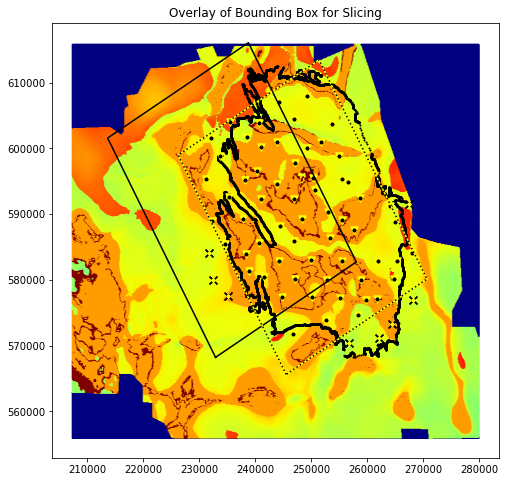

In [17]:
#move box to global coordinate location to cover the Groningen Field (this was done by eye)
#play wiht the coordinate translations to movie bounding box
xshift = 12600
yshift = -2600
old_box_x = np.copy(prbbox_x)
old_box_y = np.copy(prbbox_y)
new_box_x = np.copy(prbbox_x)
new_box_y = np.copy(prbbox_y)
new_box_x += xshift
new_box_y += yshift

irec, orec = get_in_out_recs(new_box_x,new_box_y,rec_x,rec_y)
sgf_bbox.translate(xshift,yshift)
bbirec, bborec = sgf_bbox.separateByInOut(rec_x,rec_y)

#Plot
fig, ax = plt.subplots(1,figsize=(8,8))
ax.scatter(xyc[:,0],xyc[:,1],s=1,c=surf.flatten(),cmap=plt.cm.jet,norm=surf_norm,zorder=0)
ax.scatter(mypoints[:,0],mypoints[:,1],s=1,c='black',zorder=1)
#ax.scatter(rec_x,rec_y,s=50,c='black',marker='v',zorder=2)
ax.scatter(irec[:,0],irec[:,1],s=50,c='yellow',marker='v',zorder=1)
ax.scatter(orec[:,0],orec[:,1],s=60,c='black',marker='x',zorder=1)
ax.scatter(bbirec[:,0],bbirec[:,1],s=30,c='black',marker='.',zorder=2)
ax.scatter(bborec[:,0],bborec[:,1],s=30,c='yellow',marker='.',zorder=2)
ax.plot(old_box_x,old_box_y,c='black',zorder=3)
ax.plot(new_box_x,new_box_y,c='yellow',zorder=3)
ax.plot(sgf_bbox.getCLoop()[:,0],sgf_bbox.getCLoop()[:,1],c='black',linestyle='dotted',zorder=4)
ax.set_title('Overlay of Bounding Box for Slicing')
plt.show()

## Now we have the region we want to slice. 

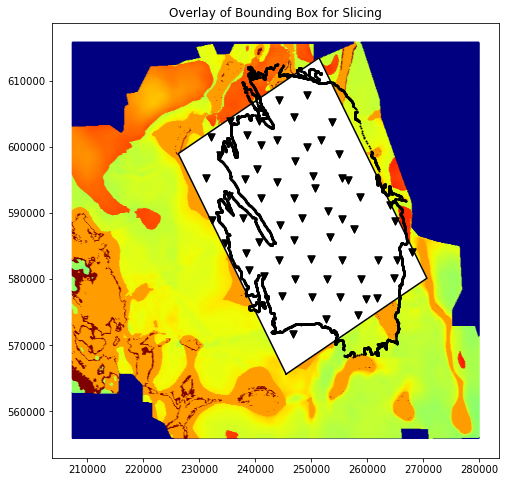

In [18]:
# need to translate the coordinates for interpolation to the coorect location
rxy = np.copy(xy)
rxy[:,0] += mybbox[0] + xshift
rxy[:,1] += mybbox[1] + yshift

#Plot
fig, ax = plt.subplots(1,figsize=(8,8))
ax.scatter(xyc[:,0],xyc[:,1],s=1,c=surf.flatten(),cmap=plt.cm.jet,norm=surf_norm,zorder=0)
ax.fill(new_box_x,new_box_y,c='white',zorder=1)
#ax.scatter(xy[:,0],xy[:,1],s=1,c=slice_surf,cmap=plt.cm.jet,norm=mynorm_slice,zorder=1)
#ax.scatter(rxy[:,0],rxy[:,1],s=1,c='white',zorder=1)
ax.scatter(mypoints[:,0],mypoints[:,1],s=1,c='black',zorder=2)
#ax.scatter(rec_x,rec_y,s=50,c='black',marker='v',zorder=2)
ax.scatter(irec[:,0],irec[:,1],s=50,c='black',marker='v',zorder=3)
ax.plot(new_box_x,new_box_y,c='black',zorder=4)
ax.set_title('Overlay of Bounding Box for Slicing')
plt.show()

### Commence the slicing!  (This one is going to take a while...)

bbox before pickle:
 {'c_loop': array([[245534.69164335, 565634.21781808],
       [226284.69164335, 598976.19586378],
       [251399.4283531 , 613476.19586378],
       [270649.4283531 , 580134.21781808],
       [245534.69164335, 565634.21781808]]), 'rotdeg': 30, 'origin': array([245534.69164335, 565634.21781808])}
bbox after pickle :
 {'c_loop': array([[245534.69164335, 565634.21781808],
       [226284.69164335, 598976.19586378],
       [251399.4283531 , 613476.19586378],
       [270649.4283531 , 580134.21781808],
       [245534.69164335, 565634.21781808]]), 'rotdeg': 30, 'origin': array([245534.69164335, 565634.21781808])}


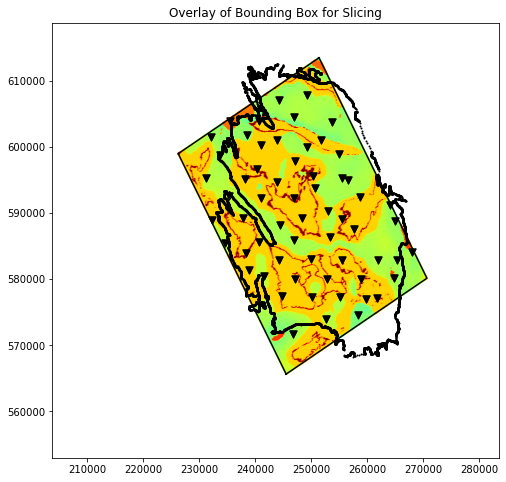

In [19]:
import pickle
#slice via xy coords and gm3d
slice_surf = gm3d.depthValsSliceFromXYCoordsZIndex(rxy,20,local=False)[0]

#Ploting normalization
vp_min_s = np.min(slice_surf)
vp_max_s = np.max(slice_surf)
mynorm_slice = Normalize(vp_min_s,vp_max_s)

#plot background NAM as white
bgbox_x = np.array([xc[0],xc[0],xc[-1],xc[-1],xc[0]])
bgbox_y = np.array([yc[0],yc[-1],yc[-1],yc[0],yc[0]])

print('bbox before pickle:\n',sgf_bbox)
f = open('./model_bbox.pickle', 'wb')
pickle.dump(sgf_bbox, f)
f.close()

f = open('./model_bbox.pickle', 'rb')
dill_bbox = pickle.load(f)
f.close()
print('bbox after pickle :\n',dill_bbox)

#Plot
fig, ax = plt.subplots(1,figsize=(8,8))
ax.fill(bgbox_x,bgbox_y,c='white',zorder=0)
ax.scatter(rxy[:,0],rxy[:,1],s=1,c=slice_surf,cmap=plt.cm.jet,norm=mynorm_slice,zorder=1)
ax.scatter(mypoints[:,0],mypoints[:,1],s=1,c='black',zorder=2)
#ax.scatter(rec_x,rec_y,s=50,c='black',marker='v',zorder=2)
ax.scatter(irec[:,0],irec[:,1],s=50,c='black',marker='v',zorder=3)
ax.plot(new_box_x,new_box_y,c='black',zorder=4)
ax.set_title('Overlay of Bounding Box for Slicing')
plt.show()

### We put it all together.

<IPython.core.display.Javascript object>


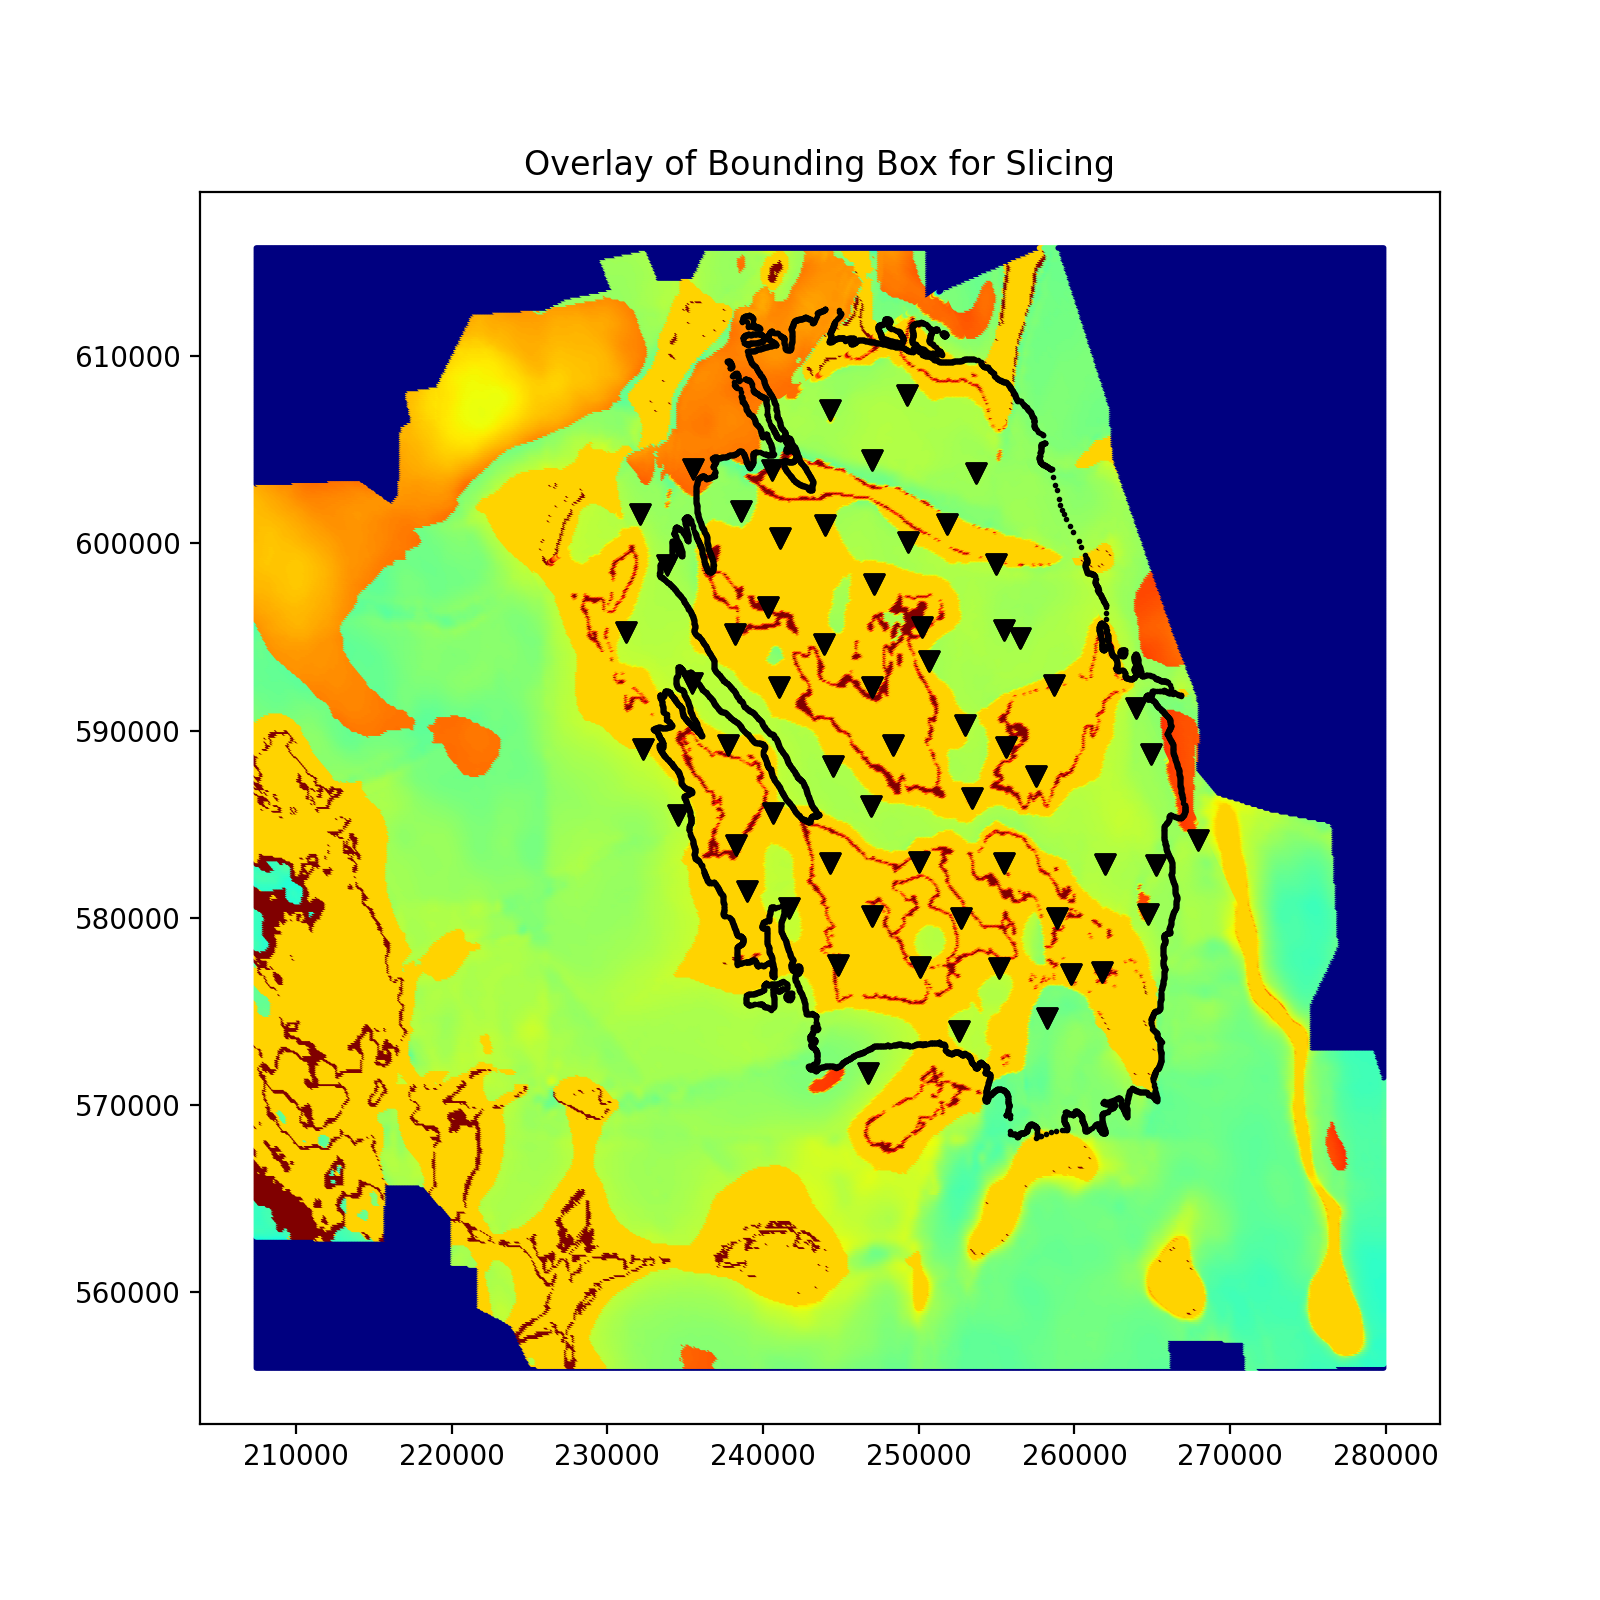

In [20]:
%matplotlib notebook
#Plot
fig, ax = plt.subplots(1,figsize=(8,8))
ax.scatter(xyc[:,0],xyc[:,1],s=1,c=surf.flatten(),cmap=plt.cm.jet,norm=mynorm_slice,zorder=0)
ax.fill(new_box_x,new_box_y,c='white',zorder=1)
ax.scatter(rxy[:,0],rxy[:,1],s=1,c=slice_surf,cmap=plt.cm.jet,norm=mynorm_slice,zorder=2)
ax.scatter(mypoints[:,0],mypoints[:,1],s=1,c='black',zorder=3)
#ax.scatter(rec_x,rec_y,s=50,c='black',marker='v',zorder=3)
ax.scatter(irec[:,0],irec[:,1],s=50,c='black',marker='v',zorder=4)
#ax.plot(new_box_x,new_box_y,c='black',zorder=5)
ax.set_title('Overlay of Bounding Box for Slicing')
plt.ion()
plt.show()